Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### Mount and read the data

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing all the important libraries

In [77]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D, BatchNormalization, RandomZoom,RandomRotation
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [57]:
# Defining the path for train and test images
basepath='/content/drive/MyDrive/EDA data/melonoma/'
data_dir_train = pathlib.Path(basepath+'Train')
data_dir_test = pathlib.Path(basepath+'Test')

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123, 
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [7]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,  
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Create a code to visualize one instance of all the nine classes present in the dataset

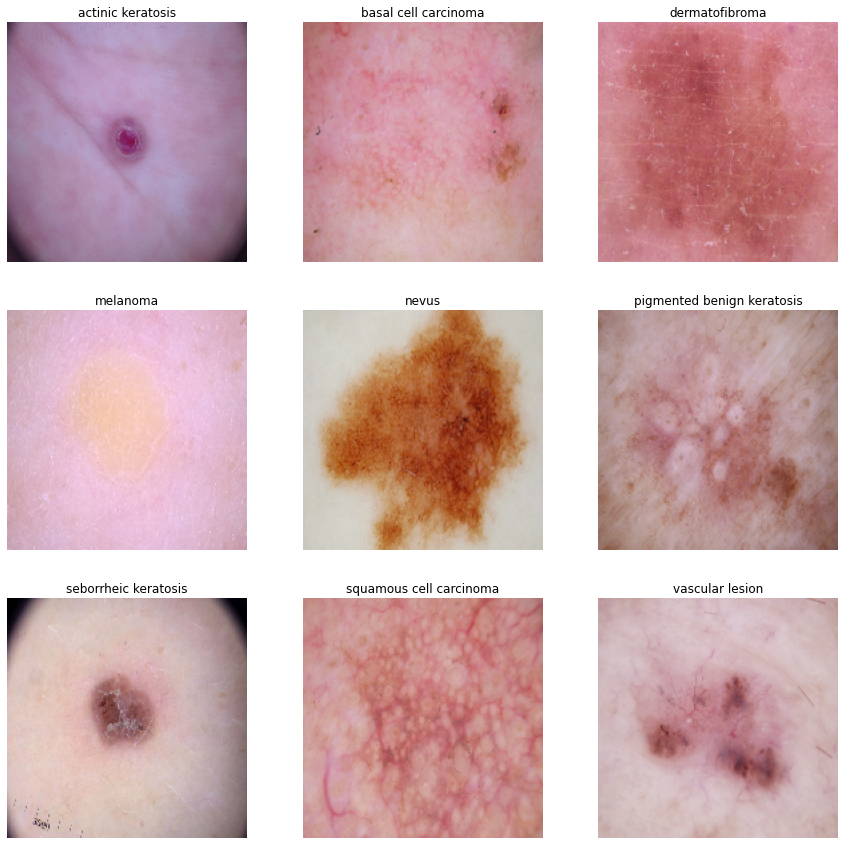

In [9]:
### Use training or validation data to visualize
plt.figure(figsize=(15, 15))
for imgs,lbl in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(imgs[i].numpy().astype("uint8"))
    plt.title(class_names[i])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
### Your code goes here
ishp = (180,180,3)

#Create models layer-by-layer with sequential
ml = Sequential()

# add the rescaling layer
ml.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=ishp))

#1st conv layer
ml.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
ml.add(layers.MaxPool2D(pool_size=(2,2)))

#2nd conv layer
ml.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
ml.add(layers.MaxPool2D(pool_size=(2,2)))

#3rd conv layer
ml.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
ml.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
ml.add(layers.Flatten())

#Dense Layer
ml.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
ml.add(layers.Dense(len(class_names),activation='softmax'))

## total number of classes in output layer is 9

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
### Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
ml.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
ml.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [14]:
epochs = 20
history = ml.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 571s 2s/step - loss: 2.0146 - accuracy: 0.2656 - val_loss: 1.7741 - val_accuracy: 0.4161
Epoch 2/20
56/56 [==============================] - 2s 40ms/step - loss: 1.6572 - accuracy: 0.4118 - val_loss: 1.5178 - val_accuracy: 0.4877
Epoch 3/20
56/56 [==============================] - 2s 39ms/step - loss: 1.4791 - accuracy: 0.4749 - val_loss: 1.5042 - val_accuracy: 0.5011
Epoch 4/20
56/56 [==============================] - 2s 39ms/step - loss: 1.3713 - accuracy: 0.5240 - val_loss: 1.3746 - val_accuracy: 0.5324
Epoch 5/20
56/56 [==============================] - 2s 39ms/step - loss: 1.3614 - accuracy: 0.5246 - val_loss: 1.3644 - val_accuracy: 0.5257
Epoch 6/20
56/56 [==============================] - 2s 39ms/step - loss: 1.2203 - accuracy: 0.5636 - val_loss: 1.3251 - val_accuracy: 0.5369
Epoch 7/20
56/56 [==============================] - 2s 39ms/step - loss: 1.1427 - accuracy: 0.5965 - val_loss: 1.6452 - val_accuracy: 0.5011
Epoch 8/20
56

### Visualizing training results

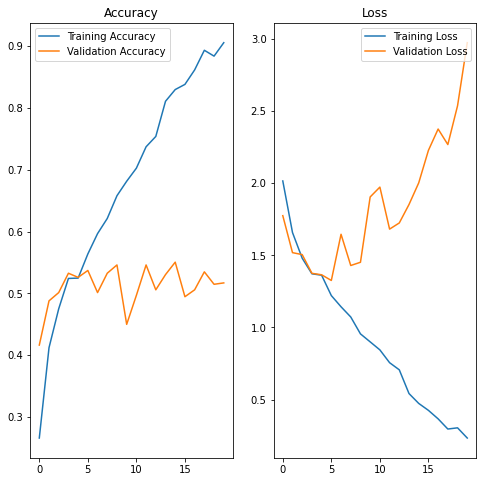

In [15]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs_range, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='upper left')
plt.title('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, history.history['loss'], label='Training Loss')
plt.plot(epochs_range, history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Loss')
plt.show()

#### Write your findings after the model fit, see if there is an evidence of model overfit or underfit

In [16]:
loss, accuracy = ml.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = ml.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Val accuracy: ",accuracy_v)
print("loss: ",loss)
print("Val loss", loss_v)


14/14 [==============================] - 0s 17ms/step - loss: 2.9728 - accuracy: 0.5168
Accuracy:  0.8978794813156128
Val accuracy:  0.5167785286903381
loss:  0.25846290588378906
Val loss 2.9728193283081055


# Observation
The network seems to be **overfit** because the training accuracy is high but the validation accuracy is much lower. The model performed well on training data but did not perform well on unseen data.

In [17]:
# After you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy. 
generatedImages = ImageDataGenerator(        
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image         
        horizontal_flip=True)  # randomly flip images

In [18]:

imgClasses = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

new_train = generatedImages.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = imgClasses,
    batch_size = 64
 )

new_val = generatedImages.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = imgClasses,
    batch_size = 64
)

Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


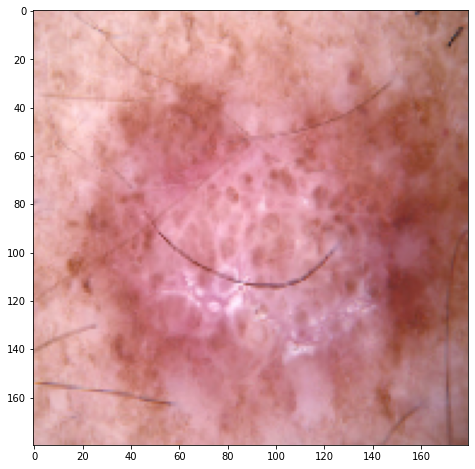

In [19]:
# visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(10,8))
image = new_train.next()[0][1].astype('uint8')
plt.imshow(image)
plt.show()

### Create the model, compile and train the model


In [20]:
#We will add the following additional preprocessing layers to our model, along with dropout layers, train the data and see if it is better
#ml.add(tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(180, 180,3)))
#ml.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.1))
#ml.add(tf.keras.layers.experimental.preprocessing.RandomZoom(0.1))

ishp = (180,180,3)

#Create models layer-by-layer with sequential
ml = Sequential()

# add the rescaling layer
ml.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=ishp))
# add few more pre processing layers to the data.
ml.add(tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(180, 180,3)))
ml.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.1))
ml.add(tf.keras.layers.experimental.preprocessing.RandomZoom(0.1))
#1st conv layer
ml.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
ml.add(layers.MaxPool2D(pool_size=(2,2)))

#2nd conv layer
ml.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
ml.add(layers.MaxPool2D(pool_size=(2,2)))

#3rd conv layer
ml.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
ml.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
ml.add(layers.Dropout(0.5))

#Flatten Layer
ml.add(layers.Flatten())

#Dense Layer
ml.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
ml.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
ml.add(layers.Dense(len(class_names),activation='softmax'))

## total number of classes in output layer is 9



### Compiling the model

In [21]:
### Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
ml.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [22]:
# View the summary of all layers
ml.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 89, 89, 32)       0         
 2D)                                                  

### Training the model

In [23]:
## Your code goes here, note: train your model for 20 epochs
epochs = 20
history = ml.fit(
  new_train,
  validation_data=new_val,
  epochs=epochs
)

Epoch 1/20
14/14 [==============================] - 73s 5s/step - loss: 1.4077 - accuracy: 0.4382 - val_loss: 1.1968 - val_accuracy: 0.2917
Epoch 2/20
14/14 [==============================] - 30s 2s/step - loss: 0.9667 - accuracy: 0.4820 - val_loss: 1.2703 - val_accuracy: 0.2917
Epoch 3/20
14/14 [==============================] - 30s 2s/step - loss: 0.8674 - accuracy: 0.5652 - val_loss: 1.6108 - val_accuracy: 0.2917
Epoch 4/20
14/14 [==============================] - 30s 2s/step - loss: 0.8222 - accuracy: 0.5978 - val_loss: 1.5080 - val_accuracy: 0.3750
Epoch 5/20
14/14 [==============================] - 30s 2s/step - loss: 0.7178 - accuracy: 0.6584 - val_loss: 1.4177 - val_accuracy: 0.4583
Epoch 6/20
14/14 [==============================] - 30s 2s/step - loss: 0.7199 - accuracy: 0.6517 - val_loss: 1.5310 - val_accuracy: 0.5208
Epoch 7/20
14/14 [==============================] - 30s 2s/step - loss: 0.6908 - accuracy: 0.6674 - val_loss: 1.6689 - val_accuracy: 0.3750
Epoch 8/20
14/14 [==

### Visualizing the results

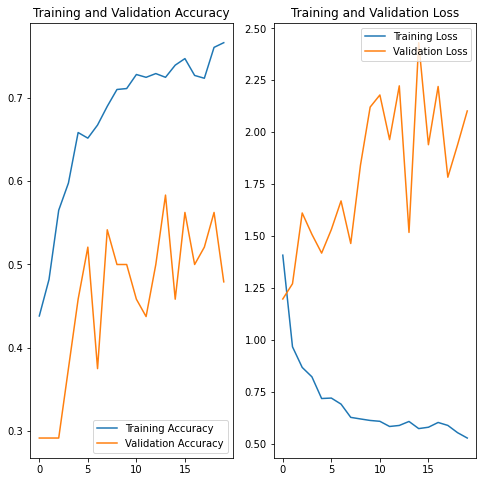

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [26]:
loss, accuracy = ml.evaluate(new_train, verbose=1,)
loss_v, accuracy_v = ml.evaluate(new_val, verbose=1)

print("Accuracy: ", accuracy)
print("Val accuracy: ",accuracy_v)
print("loss: ",loss)
print("Val loss", loss_v)

1/1 [==============================] - 4s 4s/step - loss: 2.0451 - accuracy: 0.5000
Accuracy:  0.7539325952529907
Val accuracy:  0.5
loss:  0.5397987961769104
Val loss 2.0450875759124756


# Observation
The model accuracy reduced after introducing a horizontal flip, zoom and rotation preprocessor layer. The model is still **overfit** but better than the 1st model as the difference in accuracy of train and validation is less.

#### Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [27]:
#count the number of images in each classes. If we try to perform the same on the train set, it is showing no imbalance.
#lets directly look into original data source in file system.
cnt= []
for path in pathlib.Path(data_dir_train).iterdir():
        if path.is_dir():
            cnt.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
#name of the classes
dirs = [name for name in os.listdir(data_dir_train)
                    if os.path.isdir(os.path.join(data_dir_train, name))]
    
#return dataframe with image count and class.
df= pd.DataFrame(list(zip(dirs,cnt)),columns =['class of image', 'count'])
df

,class of image,count
0,nevus,357
1,basal cell carcinoma,376
2,dermatofibroma,95
3,seborrheic keratosis,77
4,pigmented benign keratosis,462
5,squamous cell carcinoma,181
6,actinic keratosis,114
7,vascular lesion,139
8,melanoma,438


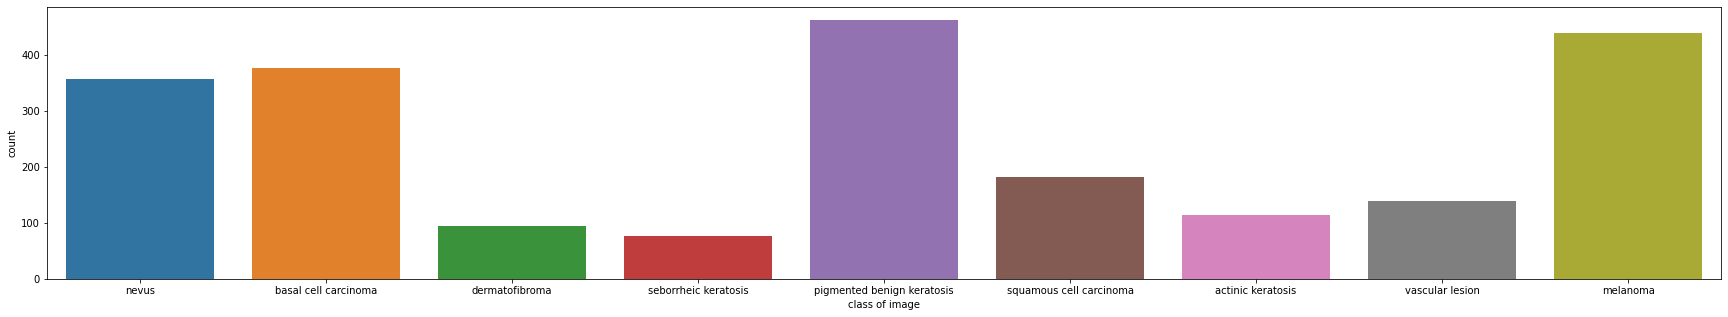

In [30]:
import seaborn as sns
plt.figure(figsize=(30, 5))
sns.barplot(y="count", x="class of image", data=df)

#### - Which class has the least number of samples? 
**Ans: seborrheic keratosis**
#### - Which classes dominate the data in terms proportionate number of samples?
**Ans: pigmented benign keratosis**

#### Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [31]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [53]:
path_to_training_dataset='/content/drive/MyDrive/EDA data/melonoma/Train/'
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/drive/MyDrive/EDA data/melonoma/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5AD5A11FA0>: 100%|██████████| 500/500 [00:19<00:00, 25.01 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/drive/MyDrive/EDA data/melonoma/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5AD6109FD0>: 100%|██████████| 500/500 [00:18<00:00, 26.73 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/drive/MyDrive/EDA data/melonoma/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5AD4794F70>: 100%|██████████| 500/500 [00:17<00:00, 28.23 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/drive/MyDrive/EDA data/melonoma/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F5AD5DD9BE0>: 100%|██████████| 500/500 [01:31<00:00,  5.47 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/drive/MyDrive/EDA data/melonoma/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7F5AD5B46280>: 100%|██████████| 500/500 [01:19<00:00,  6.27 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/drive/MyDrive/EDA data/melonoma/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5AD6090220>: 100%|██████████| 500/500 [00:18<00:00, 27.43 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/drive/MyDrive/EDA data/melonoma/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F5AD5B7DA30>: 100%|██████████| 500/500 [00:40<00:00, 12.30 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/drive/MyDrive/EDA data/melonoma/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5B51537A00>: 100%|██████████| 500/500 [00:18<00:00, 27.69 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/drive/MyDrive/EDA data/melonoma/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F5AD5C95220>: 100%|██████████| 500/500 [00:18<00:00, 27.28 Samples/s]


In [54]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123, 
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [58]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [59]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/drive/MyDrive/EDA data/melonoma/Train/nevus/output/nevus_original_ISIC_0000327.jpg_1aebd90f-928e-4d39-800d-5ed1f48ea145.jpg',
 '/content/drive/MyDrive/EDA data/melonoma/Train/nevus/output/nevus_original_ISIC_0025427.jpg_72770bd6-4017-4f21-a264-0025ceaafd48.jpg',
 '/content/drive/MyDrive/EDA data/melonoma/Train/nevus/output/nevus_original_ISIC_0000039.jpg_79066477-83b4-46fe-b0ac-2b9304e2d7da.jpg',
 '/content/drive/MyDrive/EDA data/melonoma/Train/nevus/output/nevus_original_ISIC_0000540.jpg_aa91de8d-2f39-47cd-94f2-64188185dd43.jpg',
 '/content/drive/MyDrive/EDA data/melonoma/Train/nevus/output/nevus_original_ISIC_0000467.jpg_aac43e72-d4aa-4d66-ba1f-56c2cd416d4b.jpg',
 '/content/drive/MyDrive/EDA data/melonoma/Train/nevus/output/nevus_original_ISIC_0000474.jpg_33019c68-ed6f-47ef-89d0-568ee0b5a13d.jpg',
 '/content/drive/MyDrive/EDA data/melonoma/Train/nevus/output/nevus_original_ISIC_0000082.jpg_83263568-cbcd-4184-bb0f-65f969182100.jpg',
 '/content/drive/MyDrive/EDA data/melonom

In [60]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [61]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [62]:
train_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [63]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df=df2

In [64]:
new_df['Label'].value_counts()

nevus                         500
basal cell carcinoma          500
dermatofibroma                500
seborrheic keratosis          500
pigmented benign keratosis    500
squamous cell carcinoma       500
actinic keratosis             500
vascular lesion               500
melanoma                      500
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [80]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [81]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [82]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  label_mode='categorical',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [83]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

#### Create your model

In [84]:
#Create models layer-by-layer with sequential
ml = Sequential()

# add the rescaling layer
ml.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255,input_shape=ishp))
# add few more pre processing layers to the data.
ml.add(tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(180, 180,3)))
ml.add(tf.keras.layers.experimental.preprocessing.RandomRotation(0.1))
ml.add(tf.keras.layers.experimental.preprocessing.RandomZoom(0.1))
#1st conv layer
ml.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
ml.add(layers.MaxPool2D(pool_size=(2,2)))

#2nd conv layer
ml.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
ml.add(layers.MaxPool2D(pool_size=(2,2)))

#3rd conv layer
ml.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
ml.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 50% Fraction of the input units to drop.
ml.add(layers.Dropout(0.5))

#Flatten Layer
ml.add(layers.Flatten())

#Dense Layer
ml.add(layers.Dense(128,activation='relu'))

#Dropout layer with 25% Fraction of the input units to drop.
ml.add(layers.Dropout(0.25))

#Dense Layer with softmax activation function.
ml.add(layers.Dense(len(class_names),activation='softmax'))

## total number of classes in output layer is 9

#### Compile your model

In [85]:
### Adam optimization is a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments.
ml.compile(optimizer='adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

#### Train your model

In [86]:
# using 50 epochs to train the model
epochs = 50
history = ml.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
169/169 [==============================] - 38s 89ms/step - loss: 1.8804 - accuracy: 0.2830 - val_loss: 1.4570 - val_accuracy: 0.4246
Epoch 2/50
169/169 [==============================] - 10s 57ms/step - loss: 1.5428 - accuracy: 0.4216 - val_loss: 1.3824 - val_accuracy: 0.4922
Epoch 3/50
169/169 [==============================] - 9s 56ms/step - loss: 1.4749 - accuracy: 0.4407 - val_loss: 1.3123 - val_accuracy: 0.4937
Epoch 4/50
169/169 [==============================] - 10s 56ms/step - loss: 1.3841 - accuracy: 0.4707 - val_loss: 1.2501 - val_accuracy: 0.5308
Epoch 5/50
169/169 [==============================] - 10s 57ms/step - loss: 1.3297 - accuracy: 0.4872 - val_loss: 1.1831 - val_accuracy: 0.5405
Epoch 6/50
169/169 [==============================] - 10s 56ms/step - loss: 1.3223 - accuracy: 0.4978 - val_loss: 1.1992 - val_accuracy: 0.5501
Epoch 7/50
169/169 [==============================] - 10s 56ms/step - loss: 1.2556 - accuracy: 0.5230 - val_loss: 1.1592 - val_accuracy: 

#### Visualize the model results

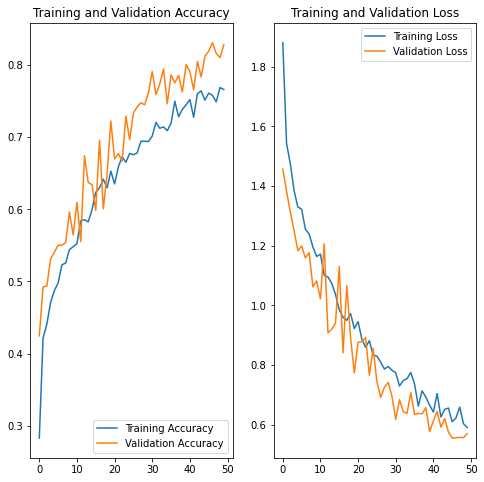

In [87]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [88]:
loss, accuracy = ml.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = ml.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Val accuracy: ",accuracy_v)
print("loss: ",loss)
print("Val loss", loss_v)

43/43 [==============================] - 1s 17ms/step - loss: 0.5702 - accuracy: 0.8278
Accuracy:  0.8868694305419922
Val accuracy:  0.8277654051780701
loss:  0.3367243707180023
Val loss 0.5701677203178406


**Model Prediction**

1/1 [==============================] - 0s 15ms/step
Actual Class: dermatofibroma
Predicted Class: dermatofibroma


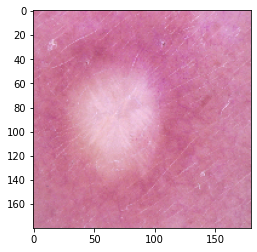

In [101]:
from glob import glob
test_image_path = os.path.join(data_dir_test, class_names[2], '*')
test_image = glob(test_image_path)
test_image = load_img(test_image[11],target_size=(180,180,3))
plt.imshow(test_image)
plt.grid(False)

img = np.expand_dims(test_image,axis=0)
pred = ml.predict(img)
pred = np.argmax(pred)
pred_class = class_names[pred]
print("Actual Class: "+ class_names[2] +'\n'+ "Predicted Class: "+pred_class )

**Final Conclusion:**


*   Final model has an training accuracy of **88.68%** with validation accuracy of **82.77%**
*   The agumentor used to balance the classes helped improve the validation accuracy.
*   The model is able to predict an unseen image from test data set correctly. The model no longer shows signs of under or over fit.

